<a href="https://www.kaggle.com/code/sgjustino/clustering-project?scriptVersionId=152540449" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction: Gather data, determine the method of data collection and provenance of the data.



Data: This fictional dataset has been obtained from a Kaggle competition - Tabular Playground Series of July 2022. This dataset is particularly challenging because it is designed for unsupervised learning with hidden clusters, meaning that we don't have labeled data typically used for supervised learning tasks. Submissions are evaluated on the Adjusted Rand Index (ARI) between the ground truth cluster labels of the data and the predicted cluster labels. This dataset is particularly relevant for this final project because it is essentially a true blue unsupervised learning problem.

Competition Description: In this challenge, you are given a dataset where each row belongs to a particular cluster. Your job is to predict the cluster each row belongs to. You are not given any training data, and you are not told how many clusters are found in the ground truth labels.

Walter Reade, Ashley Chow. (2022). Tabular Playground Series - Jul 2022. Kaggle. https://kaggle.com/competitions/tabular-playground-series-jul-2022

# Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [ ]:
data = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2022/data.csv')

data_info = data.info()
data_head = data.head()

data_info, data_head

The dataset consists of 98,000 entries and 30 columns. Interestingly, we really have no clue on what the variables mean for each column although each row is essentially an individual data based on the Id. Features 'f_00' to 'f_28' are numerical (both float and integer types), but their actual meanings are anonymized. Given the context of the competition, these features are what we would use to determine the clusters each sample belongs to.

Since we're dealing with a completely unsupervised problem, there are no predefined labels. Our goal will be to use clustering techniques to uncover any inherent groupings in the data based on the features provided.

# Identify an Unsupervised Learning Problem

Given the nature of the data and the challenge, we can safely say that this is essentially a clustering problem (using models such as K means clustering and hierarchical clustering) as we are tasked with identifying a structure in a collection of unlabeled data. The problem is particularly challenging because:

* Number of Clusters Unknown: We are not informed of the number of clusters, which is a critical parameter in many clustering algorithms like K-means. We will need to use methods for determining the optimal number of clusters or submit multiple attempts to ascertain the ARI.

* High-dimensionality: With 29 features for each sample, the high-dimensionality of the data can introduce complexity, as the distance between points becomes less meaningful in higher-dimensional spaces.

* No Ground Truth for Training: The absence of a ground truth eliminates the possibility of using supervised methods to verify our findings. Techniques like cross-validation with a known ground truth aren't possible here. Again, relegating us to unsupervised techniques.

* Evaluation Criterion: The challenge uses the Adjusted Rand Index (ARI), a measure of the similarity between two data clusterings. A higher Adjusted Rand Index indicates a better performance in predicting the ground truth cluster labels of the data from the predicted cluster labels.

Given this understanding, our next step will be to conduct an Exploratory Data Analysis (EDA) to understand the distributions, handle missing values if any, and possibly visualize the data to understand potential clusters.

# Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

For EDA, we will proceed with the steps below:

* Describe the Dataset Components: We will look into the distributions of the features using statistical summaries and visualizations.
* Check for Correlations: Identify if any features are strongly correlated with others.
* Data Cleaning: Look for any anomalies, such as missing values, outliers, or skewed information and treat the data.
* Feature Engineering: As there is 29 features, we might want to tackle the dimensionality issue, and see if we can conduct feature selection, extraction or reduction (although without contextual knowledge) to aid in subsequent modeling.

In [ ]:
descriptive_stats = data.describe()
missing_values = data.isnull().sum()

descriptive_stats, missing_values

From the initial inspection, the features have varying ranges, as indicated by the differences between their minimum and maximum values. This variation suggests that normalization or scaling may be necessary before performing clustering, as many clustering algorithms are sensitive to the scale of the data. The standard deviations suggest differing levels of variance in the features. Features with higher variance might be more influential in the clustering process, assuming the variance is due to genuine data characteristics and not noise.

There are no missing values in the dataset, as confirmed by the check for nulls. This is good as it means we can proceed without needing imputation strategies, although we may need to clean the data by normalising or scaling.

Next, we will create histograms for each feature to understand their distributions. This visual approach will help identify if any features are skewed or have outliers.

In [ ]:
plt.figure(figsize=(20, 16))

for i in range(29):
    plt.subplot(5, 6, i + 1)
    plt.hist(data[f'f_{str(i).zfill(2)}'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of f_{str(i).zfill(2)}')
    plt.tight_layout()

plt.show()

The histograms provide a visual representation of each feature's distribution. Here is what we can discern from these plots:

* Variety in Distributions: While most of the features appear to have relatively normal distribution, some features like 'f_06' and 'f_07' seemed to have skewed distribution.

* Presence of Outliers: Some histograms like 'f_09' seems to have some potential outliers. These are visible in features with long tails, indicating values significantly higher or lower than the majority of the data.

* Different Ranges: The features have varying ranges (minimum and maximum values), which could affect algorithms sensitive to scale. For instance, 'f_04' has a broader range compared to 'f_22'. 

Clearly, the visual inspection suggest the need to delve deeper into outlier detection and formulate a strategy for potentially transforming the data for optimal results in subsequent clustering or predictive modeling. But before we delve into that, we will examine the features deeper by creating a correlation matrix to see if any features are highly correlated. 

In [ ]:
correlation_matrix = data.drop(columns=['id']).corr()

plt.figure(figsize=(20, 15))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)

plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

From the correlation matrix, most features have low to moderate correlation with each other, with correlation coefficients more than -0.5 and lower than 0.5. This suggest that there is likely no collinearity issue present and each feature might carry unique information useful for clustering. With the inspection and visualisation work done, we move on to look closer at the outliers.

In [ ]:
plt.figure(figsize=(20, 16))

for i in range(29):
    plt.subplot(5, 6, i + 1)
    sns.boxplot(y=data[f'f_{str(i).zfill(2)}'])
    plt.title(f'Box plot of f_{str(i).zfill(2)}')
    plt.tight_layout()

plt.show()

The box plots reveal several insights regarding outliers in our dataset:

* Presence of Outliers: Most features have numerous outliers, as evidenced by the points located outside the "whiskers" of the box plots. These outliers could potentially skew our analyses and models subsequently.

* Varying Ranges of Feature Values: The box plots also highlight the differing ranges of values that each feature takes on, confirming what we observed in the histograms. Some features have a compact interquartile range (IQR), while others are quite spread out.

First, we will use a common technique for handling outliers, which is to cap them at a certain percentile. This approach involves setting a threshold (usually the 1st and 99th percentiles) and capping all the outliers beyond this range. This method preserves the general distribution and range of the data without the extreme values that can skew analysis. Next, we will apply standard scaling to the data. This process involves transforming the data such that each feature has a mean of 0 and a standard deviation of 1, to aid in our clustering models subsequently.

In [ ]:
for feature in data.columns[1:]:
    lower_threshold = data[feature].quantile(0.01)  
    upper_threshold = data[feature].quantile(0.99)
    data[feature] = np.where(data[feature] < lower_threshold, lower_threshold, 
                             np.where(data[feature] > upper_threshold, upper_threshold, data[feature]))

scaler = StandardScaler()
scaled_data = data.copy()
scaled_data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])  # excluding 'id' column for scaling

scaled_data.head()

So, outliers have been treated by capping them at the 1st and 99th percentiles. This approach retains the overall distribution of each feature while reducing the influence of extreme values. Features have also been scaled using standard scaling. This transformation ensures that each feature has a mean of 0 and a standard deviation of 1. 

With the data cleaning done, we will proceed with the last step of EDA - feature engineering. As we have no contextual knowledge of the data, we can utilise dimensionality reduction technique like Principal Component Analysis (PCA) to select a subset of principal components that capture the most variance in the data. This approach is not exactly feature selection in the traditional sense but serves a similar purpose by reducing the feature space.

In [ ]:
pca = PCA(n_components=min(*scaled_data.iloc[:, 1:].shape))
principal_components = pca.fit_transform(scaled_data.iloc[:, 1:])

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(14, 7))

plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
        label='Individual explained variance', color='g')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Variance Explained by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

cumulative_explained_variance

The chart and data represent the variance explained by each principal component and the cumulative variance explained. 

* Individual Explained Variance: Each bar represents the portion of total variance explained by each principal component.
* Cumulative Explained Variance: The step line represents the total variance explained up to each component. And we will use it to find the elbow.

Looking at the cumulative explained variance, we can see that there is no strong presence of very redundant features and there is no elbow present for feature selection. While we have no contextual knowledge, it seems that each original feature carries unique information, and therefore, the principal components each explain a portion of the variance. With this, we will continue our analysis with the full set of features that were scaled and removed for outliers.

# Perform Analysis Using Unsupervised Learning Models and Discussion

We will start off with the efficient K-means clustering due to its efficiency and ease of interpretation without much configuration. The challenging part of this process is determining the optimal number of clusters (k). We will use methods like the Elbow Method and the Silhouette Score to estimate the best k. In the absence of true labels, internal evaluation metrics like the Silhouette Score can be very helpful to aid our model building.

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model,n_init=10, k=(3,12))

visualizer.fit(scaled_data)     
visualizer.show()

In our plot, it's a bit challenging to determine the exact elbow point as there isn't a sharply defined one. However, it seems like after k=5, the decrease starts to become more linear, suggesting that increasing the number of clusters beyond this doesn't provide much better fitting to the data.

Another way to validate the number of clusters is by using silhouette analysis, which measures how similar an object is to its own cluster compared to other clusters. The silhouette scores range from -1 (incorrect clustering) to +1 (highly dense clustering). A high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. We will proceed to apply K-means with K=5 and perform silhouette analysis for further validation. 

In [ ]:
km = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = km.fit_predict(scaled_data.iloc[:, 1:])

silhouette_avg = silhouette_score(scaled_data.iloc[:, 1:], clusters)

print("For n_clusters =", 5, "The average silhouette_score is :", silhouette_avg)

The silhouette score = 0.03685. This suggests that the data points are on or very close to the decision boundary between two neighboring clusters. A score near 0 indicates that clusters are overlapping. Clearly our first model is unlikely to do very well in the prediction. We will try to submit this model and see how much ARI can we get with our first K-means clustering model.

In [ ]:
submission_df = pd.DataFrame({
    'Id': scaled_data.index,
    'Predicted': clusters
})

submission_df.to_csv('kmeans5_submission.csv', index=False)

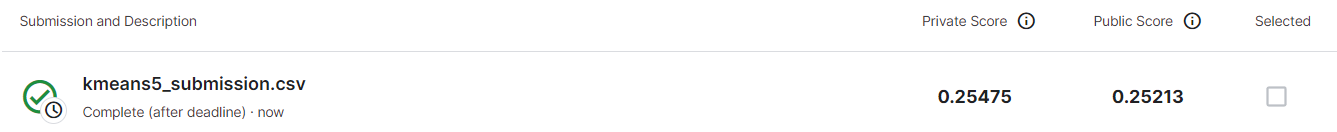

With that, our first model, K-means clustering receive an average of 0.253 across public and private scores. Next, we will try to alternate the initialization methods and random states and calculate the silhouette score for evaluation. After running these iterations, we will submit the best silhouette score model for assessment to see if we can improve the k-means clustering model.

In [ ]:
n_clusters = 5 
init_methods = ['k-means++', 'random']  
random_states = [0, 42, 100]  

results = []

for init in init_methods:
    for random_state in random_states:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, init=init, random_state=random_state)
        cluster_labels = kmeans.fit_predict(scaled_data.iloc[:, 1:])

        silhouette_avg = silhouette_score(scaled_data.iloc[:, 1:], cluster_labels)
        print(f"For n_clusters {n_clusters}, init {init}, random state {random_state}, "
              f"the average silhouette_score is: {silhouette_avg}")

        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'random_state': random_state,
            'silhouette_score': silhouette_avg
        })

results_df = pd.DataFrame(results)

top_results = results_df.sort_values(by="silhouette_score", ascending=False).head(5)
print(top_results)


Sadly, the best model turn out to be the one that we had submitted earlier. With this, we will turn to a new model that we have not tried out in the course - DBSCAN.

DBSCAN is a density-based clustering algorithm that can capture complex cluster structures and identify outliers. In K-Means, since clusters depend on the mean value of the elements, a slight change in data points affect the outcome drastically. This problem is less pronounced in DBSCAN as it identify clusters based on the idea that a cluster in data space is a contiguous region of high point density, separated from other such clusters by contiguous regions of low point density - in other words, clustering by density. Also, our results may have not done as well because we are unable to make an educated guess on the number of clusters for K-means. With DBSCAN, unlike K-Means, it doesn't require pre-specifying the number of clusters. However, it does have important hyperparameters, mainly 'eps' and 'min_samples', that significantly influence the results. We will conduct hyperparameter tuning to generate the best models based on the silhouette scores.

* eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is hard to estimate and we will use values by guess-timating and trial and error. After 5 iterations, a range of best results is shown below considering the necessity to balance memory/cpu constraints as compared to running bigger range of data.
* min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. With a sample size of 98000, we will use a rough estimation of 500 for min_samples.

The article below provide further explanation on DBSCAN.

https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

In [ ]:
eps_values = [3.9, 4.1, 4.3, 5]
min_samples_value = 500

cluster_results = []

for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=min_samples_value, metric='euclidean', n_jobs=-1)
    labels = model.fit_predict(scaled_data.iloc[:, 1:])
    
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    
    cluster_results.append({
        'eps': eps,
        'number_of_clusters': len(unique_labels),
        'cluster_sizes': label_counts
    })

for result in cluster_results:
    print(f"\n### DBSCAN with eps value: {result['eps']} ###")
    print(f"Total clusters found: {result['number_of_clusters']}")
    print(f"Sizes of clusters: {result['cluster_sizes']}")


Sadly, the results seem a bit off consider that the clusters are formed with n = 1 or 2.

At this point, instead of submitting and get a poor result, we will use PCA to project the data into 2D and then visualizing the clusters to provide insights into the clustering structure.

In [ ]:
pca_df = pd.DataFrame(data=principal_components, columns=[f'pca_{i}' for i in range(1, principal_components.shape[1] + 1)])

pca_df["dbscan_labels"] = labels

silhouette_avg = silhouette_score(scaled_data.iloc[:, 1:], labels)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="pca_1", y="pca_2", hue="dbscan_labels", palette="Spectral", edgecolor=None)
plt.title(f"Silhouette Score: {silhouette_avg:.4f}")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that there are not much segregation of clusters. Hell, there isnt even much clusters formed (2 only). This is likely due to no distinctive shape or region of higher density for DBSCAN to work effectively. On hindsight, this might have been obvious if we have inferred from our earlier PCA analysis and visualise the PCA plot. Nonetheless, it seems that this is a good lesson to understand how EDA visualisation using dimensional reduction techniques can help to determine better options for model building and why it is important to spend more time visualising 2D PCA plot to see how the shapes are formed in PCA.

Interestingly, the K-means results are likely far superior compared to DBSCAN. Following this direction, we will seek to improve our prediction by using the Gaussian Mixture Model (GMM). GMM is a probabilistic model that assumes all the data points are generated from a mixture of several Gaussian distributions. It can be a good choice for clustering when the clusters are not necessarily spherical, as in k-means. In another sense, this is an improvement of K-means through generalisation, as it calculate the probability that each observation belong to a cluster instead of assigning it to a single cluster like K-means.

For this GMM model, we will iterate over a range of cluster numbers and build the GMM model. Since the Kmeans yield a k=5. we will iterate over a range of 3-9 to capture the nuance across a range spreading around 5. We then calculate the standardised silhouette, AIC and BIC scores to select the appropriate number of clusters. In addition to silhouette scores, the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) will both be used to evaluate the fit of the GMM models. In the context of GMM, both AIC and BIC can help to choose the number of clusters by penalizing models with more parameters. Generally, lower values of AIC or BIC suggest a better model fit. Cross-referencing silhouette score with AIC and BIC might help us to determine a better number of clusters.

More information can be found in the links below:
* https://www.mygreatlearning.com/blog/gaussian-mixture-model/#What%20is%20a%20Gaussian%20Mixture%20Model?
* https://www.astroml.org/astroML-notebooks/chapter6/astroml_chapter6_Gaussian_Mixture_Models.html

In [ ]:
cluster_range = range(3, 9)

sil_scores = []
aic_scores = []
bic_scores = []

all_principal_components = pca.transform(scaled_data.iloc[:, 1:])

for n_clusters in cluster_range:
    gm = GaussianMixture(n_components=n_clusters, random_state=42)
    gm_preds = gm.fit_predict(all_principal_components)
    
    sil = silhouette_score(all_principal_components, gm_preds)
    sil_scores.append(sil)
    
    aic = gm.aic(all_principal_components)
    bic = gm.bic(all_principal_components)
    aic_scores.append(aic)
    bic_scores.append(bic)

max_aic, min_aic = max(aic_scores), min(aic_scores)
max_bic, min_bic = max(bic_scores), min(bic_scores)
max_sil, min_sil = max(sil_scores), min(sil_scores)

aic_scores = [(x-min_aic)/(max_aic-min_aic) for x in aic_scores]
bic_scores = [(x-min_bic)/(max_bic-min_bic) for x in bic_scores]
sil_scores = [(x-min_sil)/(max_sil-min_sil) for x in sil_scores]

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score', color='blue')
plt.plot(cluster_range, aic_scores, marker='o', label='AIC (normalized)', color='red')
plt.plot(cluster_range, bic_scores, marker='o', label='BIC (normalized)', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Score (standardized)')
plt.title('Standardized AIC, BIC, and Silhouette Score by Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

As seen above, the standardized plot of AIC, BIC, and silhouette score help us to visualise how different metrics can aid in decision-making. The AIC and BIC values are typically much larger than silhouette scores, so normalization helps in visualizing these metrics together.

Interestingly, the results with additional scoring criteria changes our perspective on number of clusters. As AIC/BIC may be a better scoring measurement of GMM, we can see that the trade-off occur at n=7 when we standardised the 3 metrics. Perhaps if we had included these metrics in our k selection in Kmeans clustering, we might have yielded better predictions. Nonetheless, we will proceed to fit n=7 and submit the GMM model.

In [ ]:
optimal_clusters = 7
gm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gm.fit(all_principal_components)  

labels = gm.predict(all_principal_components)

submission_df = pd.DataFrame({
    'ID': scaled_data.index,
    'Predicted': labels
})

submission_df.to_csv('GMM_submission.csv', index=False)

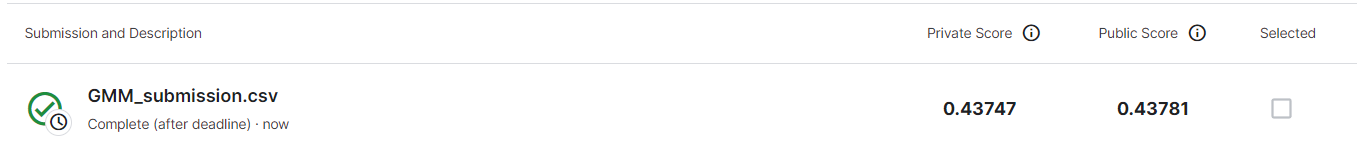

Not surprising, the submission received a much better ARI of 0.437 as compared to the earlier K-means clustering. I also wont be surprised if the K-means model of k=7 yield a closer results to the GMM model. On the other hand, besides the more optimal number of clusters, it is important to recognise that GMM provides a soft assignment of data points to clusters, meaning each data point is assigned a probability of belonging to each cluster. This probabilistic model can better handle ambiguous data points that don't clearly belong to one particular cluster as what we seen with the failed DBSCAN model. While K-Means is simpler and faster and serve well as a first-try model, GMM is more flexible and can capture more complex cluster shapes and structures - aiding our better prediction. Lastly, lets visualise our results before concluding.

In [ ]:
pca_df = pd.DataFrame(all_principal_components, columns=[f"pca_{i+1}" for i in range(all_principal_components.shape[1])])
pca_df['gmm_labels'] = labels

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x="pca_1", y="pca_2", hue="gmm_labels", palette="Spectral", edgecolor=None)
plt.title(f"GMM Clustering with {optimal_clusters} Clusters")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

As we conclude, I thought that this project is a good problem to fully explore unsupervised learning. It is definitely difficult as I am often more used to using contextual knowledge to make assessment, feature engineering and model fine-tuning. Through this assignment, the approach and different model selections and fine-tuning really help me to deepen the statistical understanding that underpins each of the 3 models explored here. In terms of improvement, I listed some points below:

- To use other scores (like how BIC/AIC introduced) early on as criteria across all models. Truthfully, it was difficult to select number of clusters in kmeans as we were restricted to the silhouette score and had no training data to work with. After the introduction of AIC/BIC, my life became easier by comparing different metrics. Searching online (first link below), it seems there are other metrics like Calinski-Harabasz Index that i could have employed in the absence of ground truth besides silhouette score.
- Being more thorough with the EDA visualistion process. After the failed DBSCAN, I realised if I had visualised a 2D PCA plot of the data, I might be able to examine different patterns such as shapes, sizes and densities. If I had done so, I might have avoided the case of trying a density-based model like DBSCAN.
- Lastly, while there were no contextual knowledge, after completing my project, I did a search on how others might have improve results on the Kaggle competition. Interesting, others have made use of the PCA plot (again) to better select features that are helpful in making better prediction (2nd link below). Their plot shows the comparison between the principal components and features used to calculate them. By looking at the values of the components we can see which features have more/less importance to each component. I thought that this is a very clever way to consider for feature selection even though my EDA shows that there are no strong correlation across features and that their individual variance explained are all quite uniform. 

Links:
* https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
* https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/334875